# COVID-19 Infection Prediction Project

## Step 0: Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Step 1: Load Data

In [6]:
print("COVID-19 INFECTION PREDICTION - ML PIPELINE")
df = pd.read_csv('covid_balanced_500.csv')
print("\n[1] Dataset Overview")
print(f"    Shape: {df.shape}")
print(f"    Columns: {df.columns.tolist()}")
print(f"\n    First 5 rows:")
print(df.head())

print(f"\n    Data Types:")
print(df.dtypes)

print(f"\n    Missing Values:")
print(df.isnull().sum())

print(f"\n    Target Distribution:")
print(df['covid_test_result'].value_counts())
print(f"    Class Balance: {df['covid_test_result'].value_counts(normalize=True)}")

COVID-19 INFECTION PREDICTION - ML PIPELINE

[1] Dataset Overview
    Shape: (500, 13)
    Columns: ['age', 'sex', 'body_temperature', 'cough', 'sore_throat', 'shortness_of_breath', 'fatigue', 'vaccination_status', 'travel_history', 'chronic_conditions', 'loss_of_smell', 'oxygen_saturation', 'covid_test_result']

    First 5 rows:
   age     sex  body_temperature  cough  sore_throat  shortness_of_breath  \
0   68    Male              97.4      1            1                    0   
1   71    Male              98.2      1            1                    1   
2   35    Male              98.8      0            1                    0   
3   40   Other              98.0      1            1                    0   
4   40  Female              99.8      1            1                    1   

   fatigue vaccination_status  travel_history  chronic_conditions  \
0        0          Partially               0                   0   
1        1              Fully               0                   0 

## Step 2: EDA

    ✓ EDA visualizations saved to 'eda_visualizations.png'


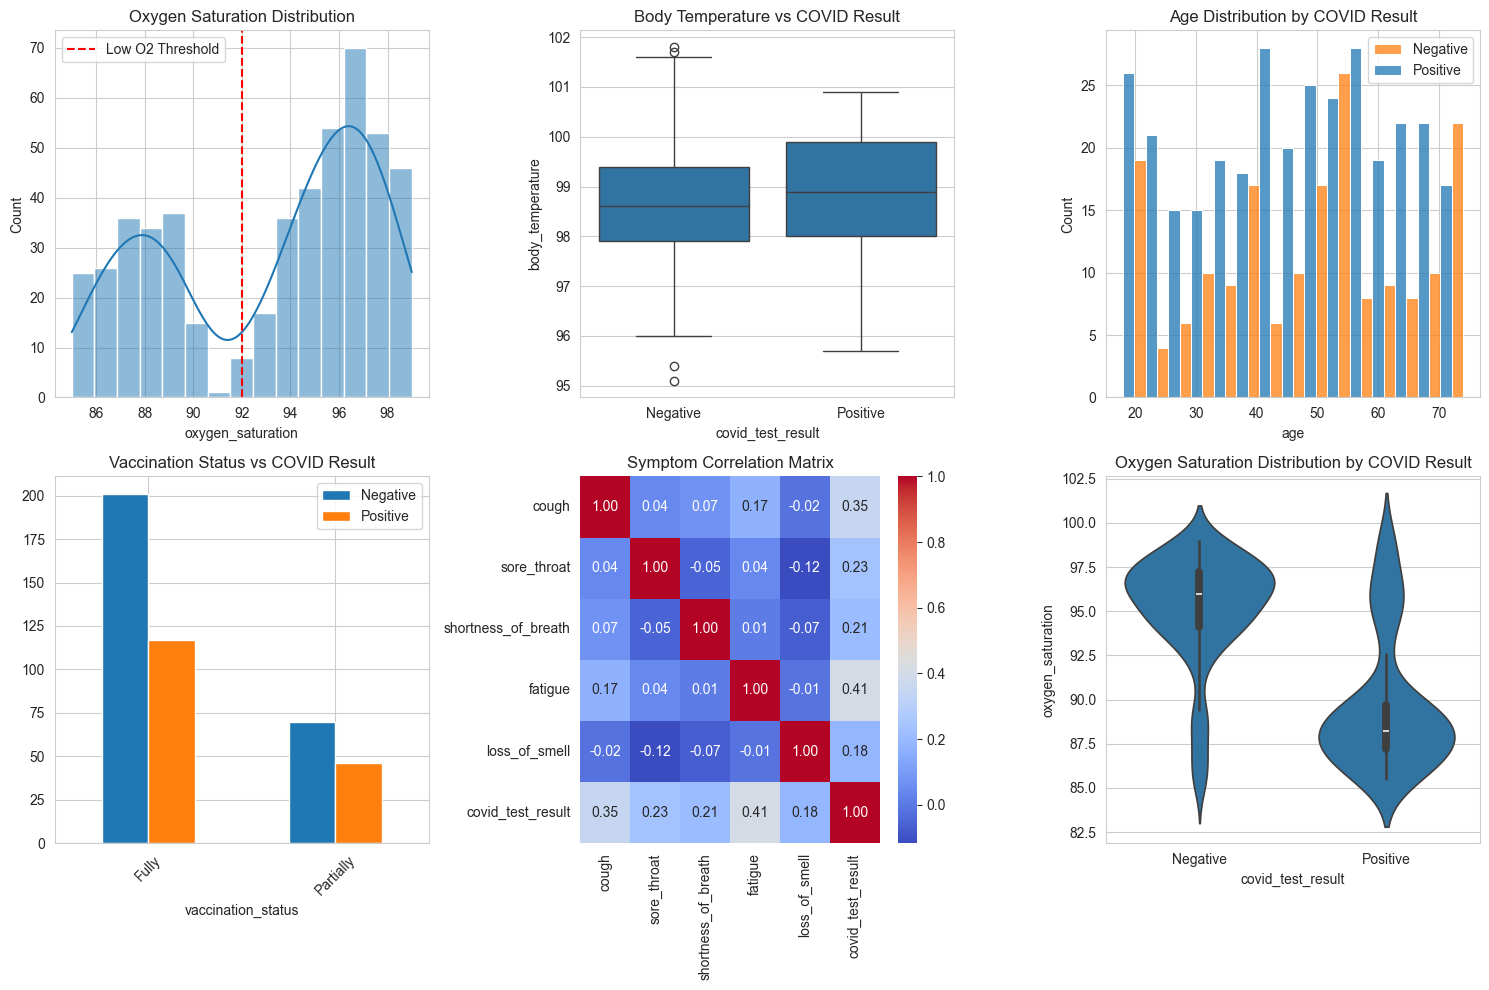

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Oxygen saturation distribution
sns.histplot(df['oxygen_saturation'], bins=15, kde=True, ax=axes[0,0])
axes[0,0].set_title('Oxygen Saturation Distribution')
axes[0,0].axvline(92, color='r', linestyle='--', label='Low O2 Threshold')
axes[0,0].legend()

# 2. Body temperature vs COVID result
sns.boxplot(x='covid_test_result', y='body_temperature', data=df, ax=axes[0,1])
axes[0,1].set_title('Body Temperature vs COVID Result')
axes[0,1].set_xticklabels(['Negative', 'Positive'])

# 3. Age distribution by COVID result
sns.histplot(data=df, x='age', hue='covid_test_result', bins=15, 
             multiple='dodge', ax=axes[0,2])
axes[0,2].set_title('Age Distribution by COVID Result')
axes[0,2].legend(labels=['Negative', 'Positive'])

# 4. Vaccination status vs COVID result
vaccination_counts = pd.crosstab(df['vaccination_status'], df['covid_test_result'])
vaccination_counts.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Vaccination Status vs COVID Result')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
axes[1,0].legend(['Negative', 'Positive'])

# 5. Symptom correlation heatmap
symptom_cols = ['cough', 'sore_throat', 'shortness_of_breath', 'fatigue', 
                'loss_of_smell', 'covid_test_result']
corr_matrix = df[symptom_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Symptom Correlation Matrix')

# 6. Oxygen saturation by COVID result
sns.violinplot(x='covid_test_result', y='oxygen_saturation', data=df, ax=axes[1,2])
axes[1,2].set_title('Oxygen Saturation Distribution by COVID Result')
axes[1,2].set_xticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("    ✓ EDA visualizations saved to 'eda_visualizations.png'")

## Step 3: Preprocessing & Feature Engineering

In [15]:
print("\nFeature Engineering")

data = df.copy()

# Create new features
print("    Creating engineered features...")

# Symptom count
data['symptom_count'] = data[['cough', 'sore_throat', 'shortness_of_breath', 
                               'fatigue', 'loss_of_smell']].sum(axis=1)

# High-risk indicator
data['high_risk'] = ((data['age'] > 60) | (data['chronic_conditions'] == 1)).astype(int)

# Fever indicator
data['fever'] = (data['body_temperature'] > 99.5).astype(int)

# Low oxygen indicator
data['low_oxygen'] = (data['oxygen_saturation'] < 92).astype(int)

# Temperature-Oxygen interaction
data['temp_oxygen_interaction'] = data['body_temperature'] * data['oxygen_saturation']

# Age groups
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 70, 100], 
                           labels=['Young', 'Middle', 'Senior', 'Elderly'])

print(f"    ✓ Created 6 new features")
print(f"    Total features: {data.shape[1]}")


print("\nData Preprocessing")

# Encode categorical variables
label_encoders = {}
categorical_cols = ['sex', 'vaccination_status', 'covid_test_result', 'age_group']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    print(f"    ✓ Encoded: {col}")

# Separate features and target
X = data.drop('covid_test_result', axis=1)
y = data['covid_test_result']

print(f"\n    Feature matrix shape: {X.shape}")
print(f"    Target vector shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n    Train set: {X_train.shape[0]} samples")
print(f"    Test set: {X_test.shape[0]} samples")
print(f"    Train class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"    Test class distribution: {pd.Series(y_test).value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"    ✓ Features scaled using StandardScaler")


Feature Engineering
    Creating engineered features...
    ✓ Created 6 new features
    Total features: 19

Data Preprocessing
    ✓ Encoded: sex
    ✓ Encoded: vaccination_status
    ✓ Encoded: covid_test_result
    ✓ Encoded: age_group

    Feature matrix shape: (500, 18)
    Target vector shape: (500,)

    Train set: 350 samples
    Test set: 150 samples
    Train class distribution: {0: 223, 1: 127}
    Test class distribution: {0: 96, 1: 54}
    ✓ Features scaled using StandardScaler


## Step 4: Model Training

In [19]:
print("\nModel Training and Comparison")
print("    Training multiple models for comparison...")

# Define models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500, 
        class_weight='balanced', 
        random_state=42,
        max_depth=20
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=300, 
        random_state=42,
        max_depth=5
    ),
    'SVM': SVC(
        kernel='rbf', 
        class_weight='balanced', 
        probability=True, 
        random_state=42
    )
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\n    Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    
    results.append(metrics)
    print(f"      ✓ Accuracy: {metrics['Accuracy']:.4f}")
    print(f"      ✓ ROC-AUC: {metrics['ROC-AUC']:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n   Best Model: {best_model_name}")
print(f"   Best ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")


Model Training and Comparison
    Training multiple models for comparison...

    Training Logistic Regression...
      ✓ Accuracy: 0.9667
      ✓ ROC-AUC: 0.9925

    Training Random Forest...
      ✓ Accuracy: 1.0000
      ✓ ROC-AUC: 1.0000

    Training Gradient Boosting...
      ✓ Accuracy: 1.0000
      ✓ ROC-AUC: 1.0000

    Training SVM...
      ✓ Accuracy: 0.9600
      ✓ ROC-AUC: 0.9983

MODEL COMPARISON RESULTS
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  1.000000   1.000000 1.000000  1.000000 1.000000
  Gradient Boosting  1.000000   1.000000 1.000000  1.000000 1.000000
                SVM  0.960000   0.913793 0.981481  0.946429 0.998264
Logistic Regression  0.966667   0.915254 1.000000  0.955752 0.992477

   Best Model: Random Forest
   Best ROC-AUC: 1.0000


## Step 5: Hyperparameter Tuning

In [20]:
print("\nHyperparameter Tuning")
print(f"   Optimizing {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [300, 500, 700],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42),
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\n    Best Parameters: {grid_search.best_params_}")
    print(f"    Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    # Use optimized model
    best_model = grid_search.best_estimator_

# ============================================================================
# STEP 7: CROSS-VALIDATION
# ============================================================================

print("\n[7] Cross-Validation Analysis")
print("    Performing 5-fold cross-validation...")

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

for metric in scoring_metrics:
    scores = cross_val_score(
        best_model, X_train_scaled, y_train, 
        cv=5, scoring=metric, n_jobs=-1
    )
    cv_results[metric] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"    {metric.upper():12s}: {scores.mean():.4f} (+/- {scores.std():.4f})")



Hyperparameter Tuning
   Optimizing Random Forest...

    Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
    Best CV ROC-AUC: 1.0000

[7] Cross-Validation Analysis
    Performing 5-fold cross-validation...
    ACCURACY    : 1.0000 (+/- 0.0000)
    PRECISION   : 1.0000 (+/- 0.0000)
    RECALL      : 1.0000 (+/- 0.0000)
    F1          : 1.0000 (+/- 0.0000)
    ROC_AUC     : 1.0000 (+/- 0.0000)


## Step 6: Cross Validation

In [21]:
print("\nCross-Validation Analysis")
print("    Performing 5-fold cross-validation...")

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

for metric in scoring_metrics:
    scores = cross_val_score(
        best_model, X_train_scaled, y_train, 
        cv=5, scoring=metric, n_jobs=-1
    )
    cv_results[metric] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"    {metric.upper():12s}: {scores.mean():.4f} (+/- {scores.std():.4f})")


Cross-Validation Analysis
    Performing 5-fold cross-validation...
    ACCURACY    : 1.0000 (+/- 0.0000)
    PRECISION   : 1.0000 (+/- 0.0000)
    RECALL      : 1.0000 (+/- 0.0000)
    F1          : 1.0000 (+/- 0.0000)
    ROC_AUC     : 1.0000 (+/- 0.0000)


## Step 7: Model Evaluation

In [22]:
print("\nFinal Model Evaluation")

# Retrain on full training set if needed
best_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, 
                          target_names=['Negative', 'Positive']))

# Confusion matrix
print("\nCONFUSION MATRIX")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Final metrics
final_accuracy = accuracy_score(y_test, y_pred)
final_roc_auc = roc_auc_score(y_test, y_proba)

print("\n" + "="*80)
print(f"FINAL TEST SET PERFORMANCE")
print("="*80)
print(f"Accuracy:  {final_accuracy:.4f}")
print(f"ROC-AUC:   {final_roc_auc:.4f}")
print("="*80)


Final Model Evaluation

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        96
    Positive       1.00      1.00      1.00        54

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


CONFUSION MATRIX
[[96  0]
 [ 0 54]]

FINAL TEST SET PERFORMANCE
Accuracy:  1.0000
ROC-AUC:   1.0000


## Step 8: Visuals


Creating Visualizations
    ✓ Evaluation visualizations saved to 'model_evaluation.png'


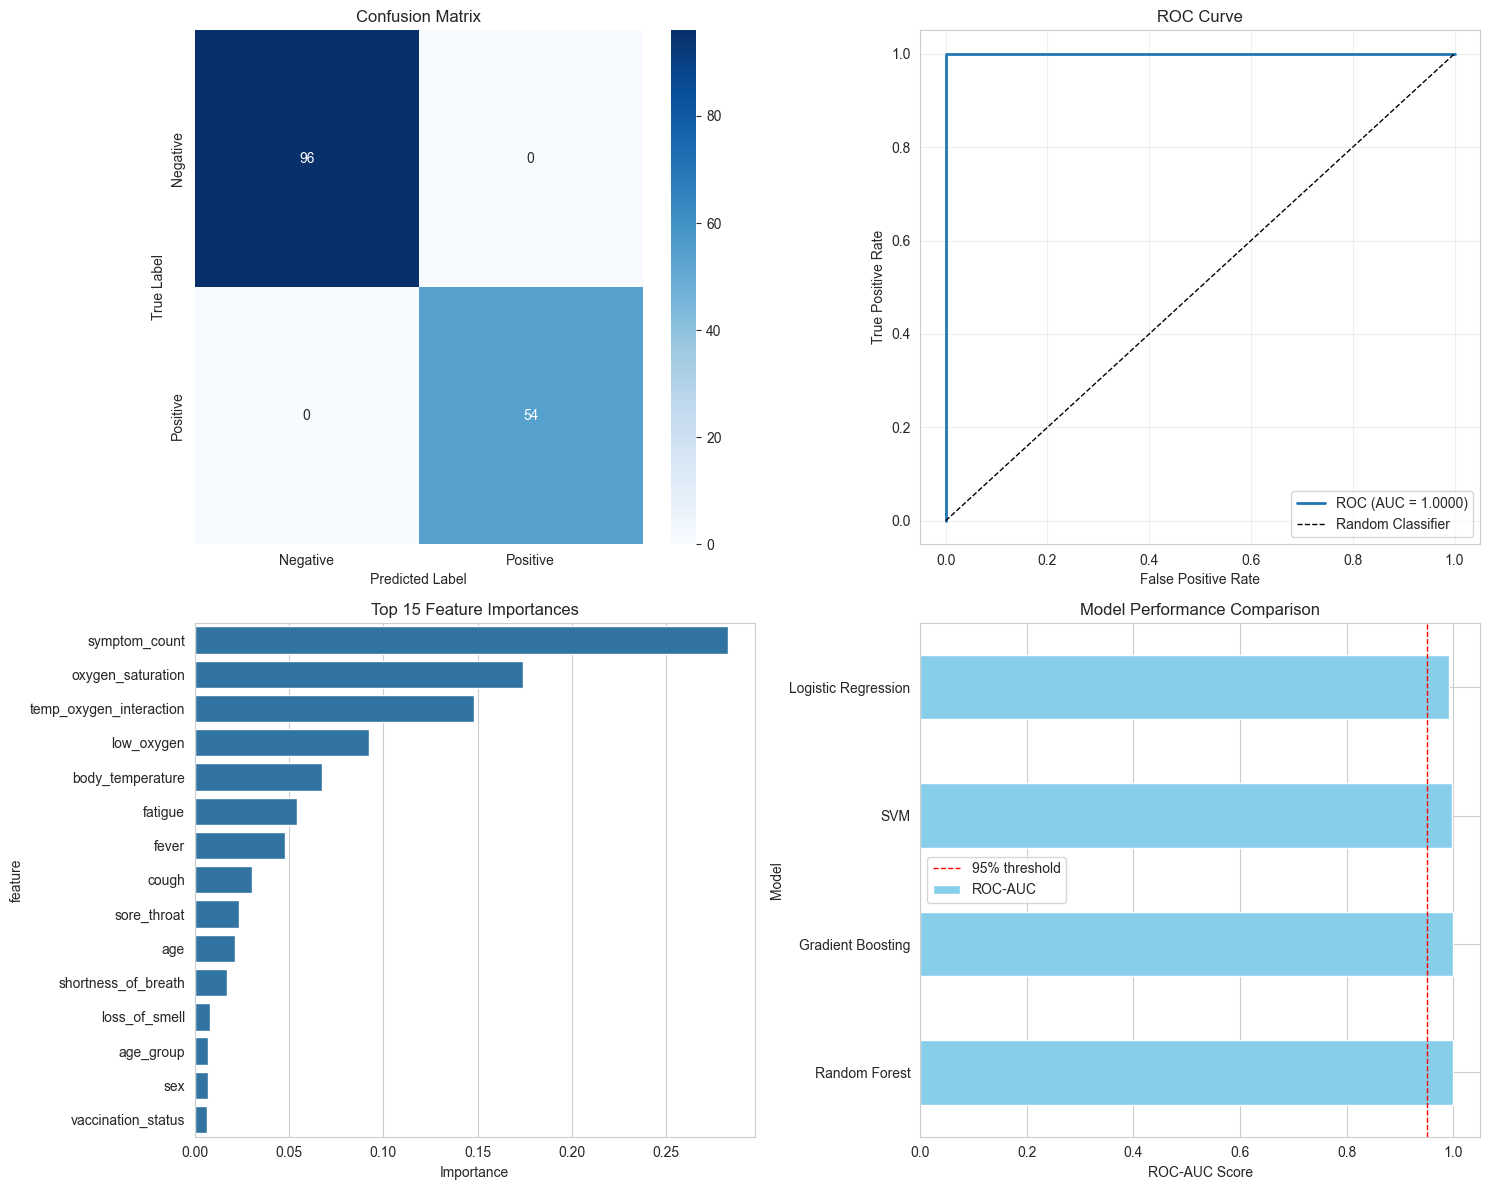

In [23]:
print("\nCreating Visualizations")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
axes[0,1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {final_roc_auc:.4f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=feature_importance, y='feature', x='importance', ax=axes[1,0])
    axes[1,0].set_title('Top 15 Feature Importances')
    axes[1,0].set_xlabel('Importance')
else:
    axes[1,0].text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
                   ha='center', va='center', fontsize=12)
    axes[1,0].set_title('Feature Importance')

# 4. Model Comparison
model_comparison = results_df.set_index('Model')['ROC-AUC']
model_comparison.plot(kind='barh', ax=axes[1,1], color='skyblue')
axes[1,1].set_xlabel('ROC-AUC Score')
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].axvline(x=0.95, color='r', linestyle='--', linewidth=1, label='95% threshold')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print("    ✓ Evaluation visualizations saved to 'model_evaluation.png'")